In [57]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import folium
from branca.element import Template, MacroElement



# 1. Завантажуємо GeoJSON з межами областей
gdf = gpd.read_file("data/full_area_ukraine_geo_v07_08_2024.geojson")
gdf= gdf[gdf['name:ua']!= 'Київ']
gdf['oblast'] = gdf['name:ua'].str.lower()



# 2. Завантажуємо дані щодо тривалості тривог
df = pd.read_csv('data/air_alerts.csv')

df[['finished_at', 'started_at']] = df[['finished_at', 'started_at']].apply(pd.to_datetime)
df['duration'] = (df['finished_at'] - df['started_at']).dt.total_seconds()
df['oblast'] = df['oblast'].str.lower()

df = df[df['level']=='oblast']

df['oblast'] = df['oblast'].replace('м. київ', 'київська область')
df['oblast'] = df['oblast'].replace('лубенський район', 'полтавська область')

### **Аналіз загальної тривалості тривог в розрізі областей**

In [58]:
# 3. З’єднуємо обидва датафрейми
group_df = df.groupby('oblast', as_index=False)['duration'].sum()

merged = gdf.merge(group_df, on='oblast', how='left')
merged['duration'] = merged['duration'].fillna(0)

merged_no_nan = merged[~merged['oblast'].isin(['автономна республіка крим', 'луганська область'])]
merged_nan = merged[merged['oblast'].isin(['автономна республіка крим', 'луганська область'])]

merged[['oblast', 'duration']].head(5)

,oblast,duration
0,луганська область,316413.0
1,кіровоградська область,12476511.0
2,одеська область,7329313.0
3,херсонська область,11919869.0
4,миколаївська область,13152323.0


/home/severyn/.local/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


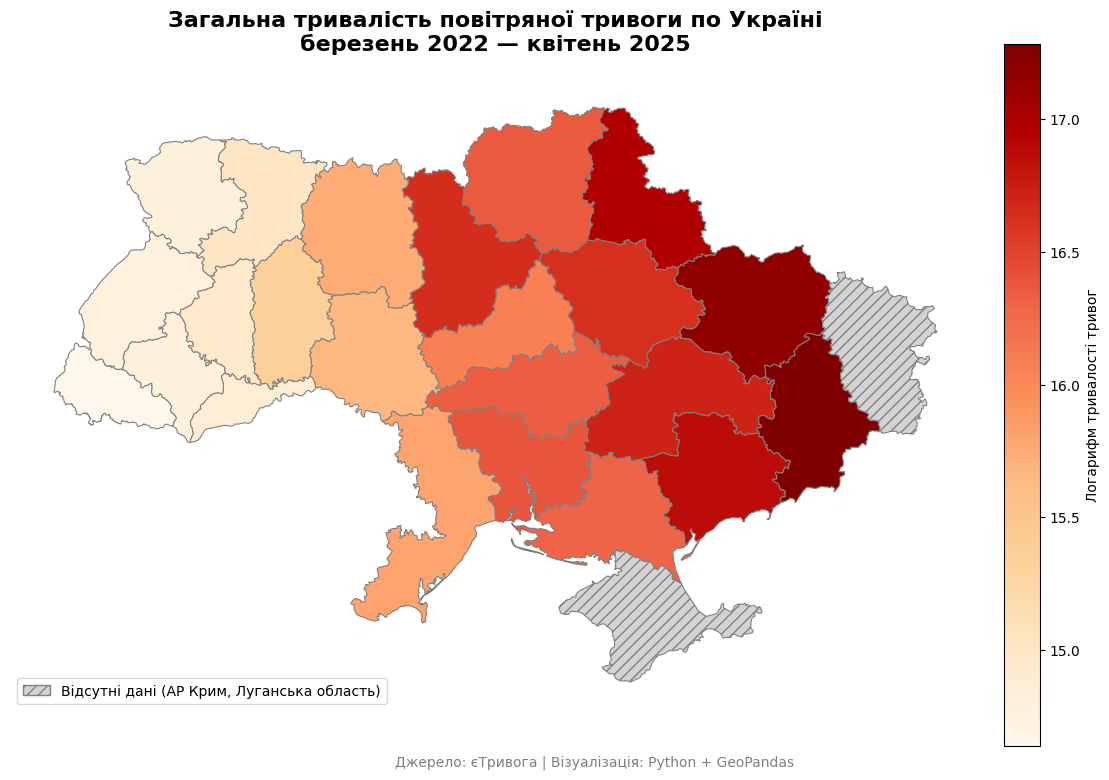

In [59]:
# 1. Обчислимо логарифмовані значення (log(1 + duration))
merged_no_nan['log_duration'] = np.log1p(merged_no_nan['duration'])

fig, ax = plt.subplots(figsize=(12, 12))

# 2. Основна мапа з log-скейлом
merged_no_nan.plot(
    column='log_duration',
    ax=ax,
    cmap='OrRd',
    linewidth=0.8,
    edgecolor='grey',
    legend=True,
    legend_kwds={
        'label': "Логарифм тривалості тривог",
        'shrink': 0.6,
        'orientation': 'vertical',
        'pad': 0.02
    },
    missing_kwds={
        "color": "lightgrey",
        "label": "немає даних"
    }
)

# 3. Області без даних - заштриховані
merged_nan.plot(
    ax=ax,
    hatch='///',
    facecolor='lightgrey',
    edgecolor='grey',
    linewidth=0.8
)

# 4. Легенда для областей без даних
legend_elements = [
    Patch(facecolor='lightgrey', hatch='///', edgecolor='grey', label='Відсутні дані (АР Крим, Луганська область)')
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=10)

# 5. Заголовок
ax.set_title(
    "Загальна тривалість повітряної тривоги по Україні\nберезень 2022 — квітень 2025",
    fontdict={'fontsize': 16, 'fontweight': 'bold'},
    pad=20
)

# 6. Підпис джерела
plt.figtext(0.5, 0.19, 'Джерело: єТривога | Візуалізація: Python + GeoPandas', 
            ha='center', fontsize=10, color='gray')

# 7. Вимкнення осей
ax.axis('off')
plt.tight_layout()
plt.show()


### **Аналіз кількості тривог в розрізі областей**

/tmp/ipykernel_234229/48712786.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged['centroid'] = merged.geometry.centroid


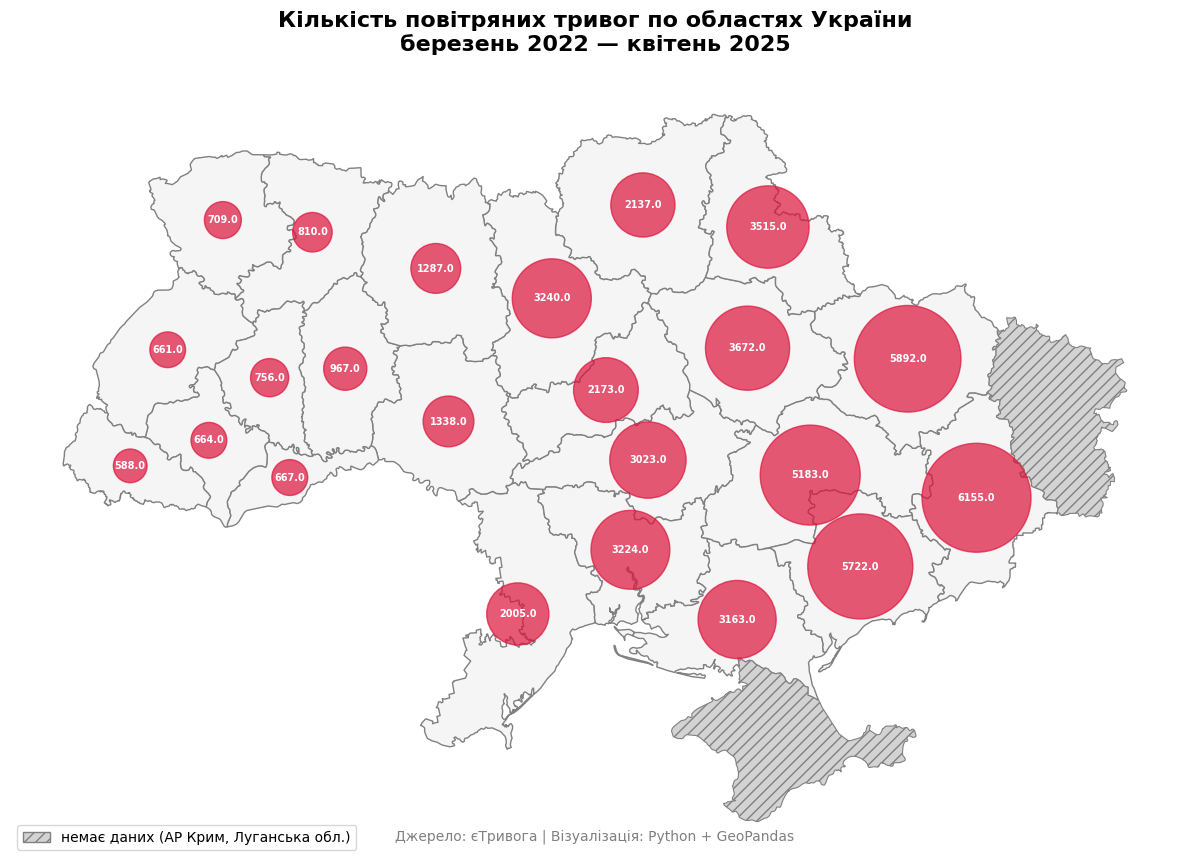

In [60]:
# 1. Підрахунок кількості тривог по областях
df['oblast'] = df['oblast'].str.strip().str.lower()
counts = df.groupby('oblast', as_index=False).size().rename(columns={'size': 'alerts_count'})


# 2. Злиття з гео-даними та центроїди
merged = gdf.copy()
merged['oblast'] = merged['oblast'].str.strip().str.lower()
merged = merged.merge(counts, on='oblast', how='left')
merged['centroid'] = merged.geometry.centroid



# 3. Центроїди для точок
centroids = gpd.GeoDataFrame(merged[['oblast', 'alerts_count']], geometry=merged['centroid'], crs=merged.crs)
centroids.loc[centroids['oblast'] == 'луганська область', 'alerts_count'] = np.nan



# 4. Відокремлюємо області з даними та без
merged_no_nan = merged[~merged['oblast'].isin(['автономна республіка крим', 'луганська область'])]
merged_nan = merged[merged['oblast'].isin(['автономна республіка крим', 'луганська область'])]



# 5. Побудова карти
fig, ax = plt.subplots(figsize=(12, 12))

# 5.1 Області з даними
merged_no_nan.plot(ax=ax, facecolor='whitesmoke', edgecolor='grey')

# 5.2 Області без даних — заштриховані
merged_nan.plot(ax=ax, hatch='///', facecolor='lightgrey', edgecolor='grey', linewidth=0.8)

# 5.3 Кружечки — кількість тривог
centroids.plot(
    ax=ax,
    markersize=centroids['alerts_count'],
    color='crimson',
    alpha=0.7
)

# 5.4 Підписи центроїдів
for x, y, label in zip(centroids.geometry.x, centroids.geometry.y, centroids['alerts_count']):
    if pd.notna(label):
        ax.text(x, y, str(label), fontsize=7, ha='center', va='center', color='white', weight='bold')

        

# 6. Заголовок
ax.set_title(
    "Кількість повітряних тривог по областях України\nберезень 2022 — квітень 2025",
    fontdict={'fontsize': 16, 'fontweight': 'bold'},
    pad=20
)



# 7. Пояснення в легенді
legend_elements = [
    Patch(facecolor='lightgrey', hatch='///', edgecolor='grey', label='немає даних (АР Крим, Луганська обл.)')
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=10)



# 8. Підпис джерела
plt.figtext(0.5, 0.19, 'Джерело: єТривога | Візуалізація: Python + GeoPandas',
            ha='center', fontsize=10, color='gray')



# 9. Прибирання осей
ax.axis('off')
plt.tight_layout()
plt.show()

### **Аналіз загальної тривалості тривог (Інтерактивна-Folium карта)**

In [63]:
# З’єднуємо датафрейми
group_df = df.groupby('oblast', as_index=False)['duration'].sum()

merged = gdf.merge(group_df, on='oblast', how='left')
merged['duration'] = merged['duration'].fillna(0)

merged_no_nan = merged[~merged['oblast'].isin(['автономна республіка крим', 'луганська область'])]
merged_nan = merged[merged['oblast'].isin(['автономна республіка крим', 'луганська область'])]
merged_no_nan['duration'] = (merged_no_nan['duration'] / (60*60*60)).round(1)  # з секунд до годин

merged_no_nan[['oblast', 'duration']].head(5)

/home/severyn/.local/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,oblast,duration
1,кіровоградська область,57.8
2,одеська область,33.9
3,херсонська область,55.2
4,миколаївська область,60.9
5,дніпропетровська область,84.2


In [64]:
# 1. Шкалюємо тривалість тривог через логарифм та підготовуємо лейбли
merged_no_nan['log_duration'] = np.log1p(merged_no_nan['duration'])  # log(1 + x)
merged_no_nan['duration_hours_label'] = (merged_no_nan['duration']).round(0).astype(int).astype(str)



# 2. Створюємо Folium карту
m = folium.Map(location=[48.4, 31.2], zoom_start=6, tiles='cartodb positron')



# 3. Полігони областей з даними
choropleth = folium.Choropleth(
    geo_data=merged_no_nan.to_json(),
    data=merged_no_nan,
    columns=['oblast', 'log_duration'],
    key_on='feature.properties.oblast',
    fill_color='YlOrRd',
    fill_opacity=0.75,
    line_opacity=0.4,
    nan_fill_color='lightgray',
    legend_name='Сумарна тривалість тривог (години, логарифмічна шкала)',
    highlight=True,
).add_to(m)



# 4. Генеруємо підписи по областям/полігонам
folium.GeoJsonTooltip(
    fields=['oblast', 'duration_hours_label'],
    aliases=['Область:', 'Тривалість (год):'],
    localize=True,
    sticky=False,
    labels=True,
).add_to(choropleth.geojson)



# 5. Шар для відсутніх даних (Крим, Луганська область)
folium.GeoJson(
    data=merged_nan[['oblast', 'duration', 'geometry']].to_json(),
    style_function=lambda feature: {
        'fillColor': 'gray',
        'color': 'gray',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.5,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['oblast'],
        aliases=['Область без даних:'],
        sticky=True
    ),
    name='Області без даних',
).add_to(m)



# 6. Легенда для областей без даних
legend = """
{% macro html(this, kwargs) %}

<div style="
    position: fixed;
    bottom: 40px;
    left: 50px;
    width: 220px;
    height: 70px;
    background-color: white;
    border:2px solid grey;
    z-index:9999;
    font-size:14px;
    padding: 10px;
">
<b>Умовні позначення:</b><br>
<div style="background:lightgray;border:1px dashed gray;width:20px;height:10px;display:inline-block;margin-right:6px"></div> — відсутні дані</div>
{% endmacro %}
"""
macro = MacroElement()
macro._template = Template(legend)
m.get_root().add_child(macro)



# 7. Зберігаємо карту
m.save("interactive_alert_duration_map.html")
m

/home/severyn/.local/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/severyn/.local/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### **Аналіз кількості тривог в розрізі областей (Інтерактивна-Folium карта)**

In [65]:
# 1. Підрахунок кількості тривог по областях
df['oblast'] = df['oblast'].str.strip().str.lower()
counts = df.groupby('oblast', as_index=False).size().rename(columns={'size': 'alerts_count'})



# 2. Злиття з гео-даними та центроїди
merged = gdf.copy()
merged = merged.merge(counts, on='oblast', how='left')
merged['centroid'] = merged.geometry.centroid

merged_no_nan = merged[~merged['oblast'].isin(['автономна республіка крим', 'луганська область'])]
merged_nan = merged[merged['oblast'].isin(['автономна республіка крим', 'луганська область'])]



# 3. Створюємо Folium карту
m = folium.Map(location=[48.4, 31.2], zoom_start=6, tiles='cartodb positron')



# 4. Полігони областей з даними
folium.GeoJson(
    data=merged_no_nan[['oblast', 'geometry', 'alerts_count']].to_json(),
    style_function=lambda feature: {
        'fillColor': 'whitesmoke',
        'color': 'gray',
        'weight': 1,
        'fillOpacity': 0.3,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['oblast', 'alerts_count'],
        aliases=['Область:', 'Кількість тривог:'],
        localize=True,
        sticky=True
    ),
    name='Області з даними'
).add_to(m)



# 5. Шар для відсутніх даних (Крим, Луганська область)
folium.GeoJson(
    data=merged_nan[['oblast', 'geometry', 'alerts_count']].to_json(),
    style_function=lambda feature: {
        'fillColor': 'lightgray',
        'color': 'gray',
        'weight': 1,
        'dashArray': '5, 5',  # штрихування
        'fillOpacity': 0.5,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['oblast'],
        aliases=['Область без даних:'],
        sticky=True
    ),
    name='Області без даних',
).add_to(m)



# 6. Масштабування центроїдів
for _, row in centroids.iterrows():
    if pd.notna(row['alerts_count']):
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=row['alerts_count']**0.5 * 0.3,  # масштаб (sqrt * 0.3)
            color='crimson',
            fill=True,
            fill_color='crimson',
            fill_opacity=0.7,
            tooltip=f"{row['oblast'].title()}: {int(row['alerts_count'])} тривог"
        ).add_to(m)

        
        
# 7. Кастомна легенда
legend_html = """
{% macro html(this, kwargs) %}

<div style="
    position: fixed;
    bottom: 40px;
    left: 50px;
    width: 260px;
    background-color: white;
    border:2px solid grey;
    z-index:9999;
    font-size:14px;
    padding: 10px;
">
<b>Умовні позначення:</b><br>
<div style="background:lightgray;border:1px dashed gray;width:20px;height:10px;display:inline-block;margin-right:6px"></div>
Області без даних<br>
<div style="background:crimson;width:20px;height:10px;display:inline-block;margin-right:6px"></div>
Кількість тривог
</div>

{% endmacro %}
"""
macro = MacroElement()
macro._template = Template(legend_html)
m.get_root().add_child(macro)




# 8. Зберігаємо карту
m.save("interactive_alerts_count_map.html")
m

/tmp/ipykernel_234229/125998274.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged['centroid'] = merged.geometry.centroid


## **Висновки**
---

### Вибір типу візуалізації

Для аналізу просторового розподілу повітряних тривог було обрано **картографічну візуалізацію**, оскільки саме карта дозволяє найкраще показати **географічні відмінності та розмежування** між регіонами. Такий формат є **інтуїтивно** зрозумілим та ефективним для виявлення **просторових закономірностей** у даних.

Для візуального кодування інтенсивності тривог використано градієнт **червоної** кольорової гами (**OrRd**), де:
- $\textcolor{darkred}{\textbf{Темніші відтінки червоного}}$ - позначають **вищу** тривалість тривог,
- $\textcolor{lightcoral}{\textbf{Світліші}}$ — відповідно **нижчу** інтенсивність,
- $\textcolor{gray}{\textbf{Сірі заштриховані області}}$ - відображають **відсутність** даних.

Використання саме червоної кольорової гами зумовлено її асоціацією з тривогою, що робить візуальне сприйняття більш природним і зрозумілим.

---

### Ключові спостереження

- **Східні** та **центральні** області України зазнали **найбільшої** кількості та **тривалості** тривог, що пояснюється їх **близькістю** до лінії фронту.


- **Західні** області мають помітно **нижчі** показники.


- Для **Луганської** області та **АР Крим**  якісні дані **відсутні**, що окремо позначено на карті.

---

**Примітка**: дані отримані з сервісу **«ЄТривога»** та потенційно можуть містити **незначні** похибки або ж **пропуски**.


